- Recombine the final sequece and croos over between the weak links -> needed a custum function, maybe full deterministic
- Stats and dataframe for the SNP and other variants
- Implement gaps NNNNN

In [22]:
# Implementation using tensors
import tensorflow as tf


read_1 = "ATTTAggggTA"
read_1 = read_1.upper()

read_2 = "ATTCGGATCGA"
read_2 = read_2.upper()

read_tf_2 = tf.constant([ord(c) for c in read_2])
read_tf_1 = tf.constant([ord(c) for c in read_1])
read_tf_1.get_shape()[0]
# read_tf = tf.strings.unicode_encode(read_tf, "UTF-8")

for i in range(read_tf_1.get_shape()[0]):
    print(i)

TypeError: 'float' object cannot be interpreted as an integer

### Here trying parallelization with Numba e prange

### Changing the final reconstruction function
- return matrix
- paralleize the coding/decoding in number
- make a separe function for the consensus
- probably is better to make lower the memory usage, since the consensus matrix will be in the same order of the length

### Graph embeddings

In [21]:
import sys
import os
sys.path.insert(0, os.path.abspath('../Main/lib'))

from numba import jit
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.io import loadmat
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from colony import *



def plot_dendrogram(model, plot_save_path):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0

        for child_idx in merge:

            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.savefig(plot_save_path)



matrix = loadmat("C:\\Users\\filoa\\Desktop\\Programming_trials\\Assembler\\Main\\Data\\graph_metadata.mat")["data"]

# print(dist_mat)

cl = AgglomerativeClustering(compute_distances=True, distance_threshold = 0.5,  n_clusters=None, metric="precomputed", linkage="single").fit(dist_mat)

# plot the top three levels of the dendrogram
plot_dendrogram(cl, truncate_mode = "level", p=3)



NameError: name 'dist_mat' is not defined

Graph with 100 nodes and 2500 edges


Generating walks (CPU: 1): 100%|██████████| 200/200 [00:06<00:00, 32.07it/s]


[-0.16132005  0.04886023  0.20149666  0.0211578  -0.00675263  0.08496967
  0.07259896 -0.02023398 -0.02976386 -0.00383045  0.21040133  0.14953811
  0.11753489 -0.13744292 -0.02059831 -0.15416609  0.03709446  0.07536242
 -0.04486865 -0.02487553 -0.18150371 -0.10682649 -0.10381406  0.23001654
  0.19979303  0.14949706  0.07235057  0.12081597 -0.1533072  -0.10069074]
[-0.06699155 -0.00174522  0.03455402 -0.02369677  0.07341821  0.02174983
  0.10203474 -0.12348919  0.07328421  0.1912131  -0.05056306  0.18172422
  0.17381047 -0.1011651  -0.18284743 -0.06206153  0.16890815  0.16366956
 -0.0721525   0.05781355 -0.06937268 -0.17231913 -0.26220784  0.15292864
  0.08065176  0.09719405 -0.03483326  0.25980502 -0.03603813 -0.09986053]
[ 0.01784923 -0.00747003 -0.06959153  0.1412673   0.1448853   0.02738258
 -0.09314834  0.0133621  -0.20960666  0.07813469  0.07893223  0.04356074
  0.10593738 -0.07550798 -0.2525145   0.01445565  0.39428306  0.07135387
 -0.00522487 -0.06470124  0.02177364 -0.13801531 

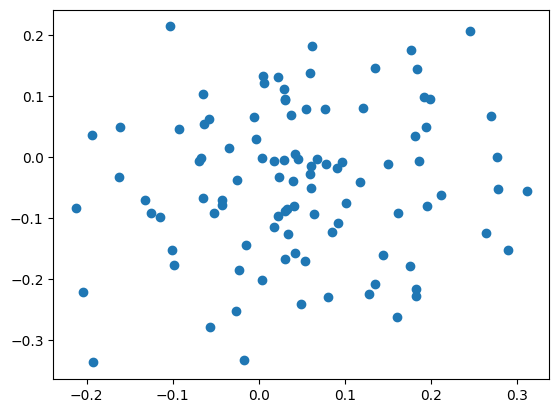

In [35]:
from node2vec import Node2Vec 
import networkx as nx
from scipy.io import loadmat
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


class graph_embed():
    
    def __init__(self, edges, dist_threshold= 0.5, dimensions=30, walk_length=50, num_walks=200, workers=1,
                window=10, min_count=1, batch_words=4,  linkage="single"):
        self.edges = edges
        self.dist_matrix = loadmat()
        self.graph = nx.DiGraph()
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.workers = workers
        self.window = window
        self.min_count = min_count
        self.batch_words = batch_words
        self.linkage = linkage
        self.dist_threshold = dist_threshold
        self.model=None
        self.embed=None
        self.x_cord=None
        self.y_cord=None
        

    def embed(self):
        "Build the graph through networkx with the edges evaluated before"
        self.graph.add_weighted_edges_from([(self.edges[0], self.edges[1], self.edges[4]) for i in self.edges])

        node2vec = Node2Vec(self.graph, dimensions=self.dimensions, walk_length=self.walk_length, num_walks=self.num_walks, workers=self.workers)

        self.embed = node2vec.fit(window=self.window, min_count=self.min_count, batch_words=self.batch_words)

        vector_list = [self.embed.wv.get_vector(node) for node in self.embed.wv.index_to_key]

        pca = PCA(n_components=2)
        comp = pca.fit(vector_list).transform(vector_list)

        self.x_cord = [i[0] for i in comp]
        self.y_cord = [i[1] for i in comp]
        

    def cluster(self):
        "This part performe the hierarchical clustering to the matrix distance between each point/node"

        self.model = AgglomerativeClustering(compute_distances=True, distance_threshold = self.dist_threshold,  n_clusters=None,
                                            metric="precomputed", linkage=self.linkage).fit(self.dist_mat)

    
    def __associate_cluster__(self):
        raise NotImplemented

    def plot_dendrogram(self, plot_save_path="dendrogram_cluster"):
        # Create linkage matrix and then plot the dendrogram

        # create the counts of samples under each node
        counts = np.zeros(self.model.children_.shape[0])
        n_samples = len(self.model.labels_)
        for i, merge in enumerate(self.model.children_):
            current_count = 0

            for child_idx in merge:

                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count

        linkage_matrix = np.column_stack(
            [self.model.children_, self.model.distances_, counts]
        ).astype(float)

        # Plot the corresponding dendrogram
        plt.title("Hierarchical Clustering Dendrogram")
        dendrogram(linkage_matrix)
        plt.xlabel("Number of points in node (or index of point if no parenthesis).")
        plt.savefig(plot_save_path)


    def plot_embed(self, plot_save_path="embed_plot"):

        plt.scatter(self.x_cord, self.y_cord)
        plt.savefig(plot_save_path)



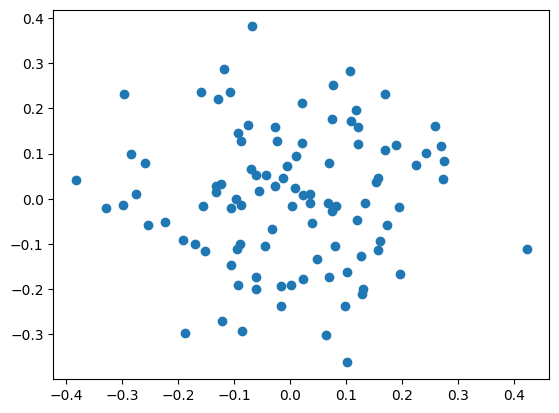

In [36]:
graph = nx.DiGraph()
# nx_graph.add_weighted_edges_from([(edges[0], edges[1], edges[4]) for i in edges])
graph.add_weighted_edges_from([(1, 2, 0.5), (3, 1, 0.75)])
graph.out_degree(1, weight='weight')

# Create a graph
graph = nx.fast_gnp_random_graph(n=100, p=0.5)
print(graph)

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=30, walk_length=50, num_walks=200, workers=1)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

pca = PCA(n_components=2)
x = [model.wv.get_vector(node) for node in model.wv.index_to_key]
comp = pca.fit(x).transform(x)
a = [i[0] for i in comp]
b = [i[1] for i in comp]
plt.scatter(a,b)